## Libraries

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase

## Connect to Neo4J database

In [34]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Neo4J1234"))
session = driver.session()

## Extractions

### Extract cases

In [7]:
query = f'''Match (e:Event) 
where e.CaseID is not null
return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,e.CaseID,e.Activity,e.Nombre,e.KitID,e.Usuario,e.timestamp,e.`Código`,e.NS
0,HNB-OFT.010-8-CN16357,Entrada Material Sucio,Parpados 08,HNB-OFT.010-8,VA,2022-03-31 12:39:00+00:00,HNB-OFT.010,8
1,HUBU-TR.008-1-CN16358,Entrada Material Sucio,Motores Linvatec Baterias 01,HUBU-TR.008-1,VA,2022-03-31 12:39:00+00:00,HUBU-TR.008,1
2,HUBU-TR.012-1-CN16359,Entrada Material Sucio,Motores Linvatec Electricos 01,HUBU-TR.012-1,VA,2022-03-31 12:38:00+00:00,HUBU-TR.012,1
3,HNB-CV.008-1-CN16360,Entrada Material Sucio,Amputación 01,HNB-CV.008-1,VA,2022-03-31 12:38:00+00:00,HNB-CV.008,1
4,HNB-CG.001-12-CN16361,Entrada Material Sucio,Laparotomia 12,HNB-CG.001-12,VA,2022-03-31 12:38:00+00:00,HNB-CG.001,12


In [ ]:
csv_file_path = "/Users/abdalrhman/Documents/preparationphase/data/27-2_output.csv"
df.to_csv(csv_file_path, index=False)

### Extract processes

In [ ]:
query = f'''Match (n:Run)
return distinct(n.activities) as process_cycle, count(n.activities) as repetition
order by count(n.activities) desc
'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
dataframe = pd.DataFrame(records, columns=columns)
dataframe.head()

In [ ]:
csv_file_path = "/Users/abdalrhman/Documents/preparationphase/data/27-2_processes_output.csv"
dataframe.to_csv(csv_file_path, index=False)

## Statistics

### Activity duration statistics

In [36]:
query = f'''match (e:Entity)<-[:HAS_RUN]-(r:Run)
match (start:Event) - [:OBSERVED] -> (c:Class )
match (end:Event) - [:OBSERVED] -> (c2:Class )
match (start) - [:CORR] -> (r)
match (end) - [:CORR] -> (r)
match (start) - [:DF] -> (end)
match (c) - [df:DF_C] ->(c2)
where df.count > 100
return start.Activity, end.Activity, start.timestamp, end.timestamp'''
frame = pd.DataFrame(session.run(query).data())
frame['start.timestamp'] = pd.to_datetime(frame['start.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['end.timestamp'] = pd.to_datetime(frame['end.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['durationDays'] = (frame['end.timestamp'] - frame['start.timestamp']).dt.total_seconds() / 60 / 60 / 24
frame['durationMinutes'] = (frame['end.timestamp'] - frame['start.timestamp']).dt.total_seconds() / 60 
frame.head()

,start.Activity,end.Activity,start.timestamp,end.timestamp,durationDays,durationMinutes
0,Entrada Material Sucio,Cargado en carro L+D,2022-03-31 11:45:00+00:00,2022-03-31 11:54:00+00:00,0.006250,9.0
1,Carga L+D iniciada,Carga L+D liberada,2022-03-31 12:50:00+00:00,2022-03-31 13:48:00+00:00,0.040278,58.0
2,Cargado en carro L+D,Carga L+D iniciada,2022-03-31 12:47:00+00:00,2022-03-31 12:50:00+00:00,0.002083,3.0
3,Entrada Material Sucio,Cargado en carro L+D,2022-03-31 11:14:00+00:00,2022-03-31 12:47:00+00:00,0.064583,93.0
4,Entrada Material Sucio,Entrada Material Sucio,2022-03-31 10:51:00+00:00,2022-03-31 15:46:00+00:00,0.204861,295.0


In [37]:
grouped = frame.groupby(['start.Activity', 'end.Activity'])['durationMinutes'].describe()
grouped.head()

count        mean          std  \
start.Activity     end.Activity                                             
Carga L+D iniciada Carga L+D iniciada     8284.0    2.050459    13.563133   
                   Carga L+D liberada    12098.0   85.391056    91.465433   
                   Cargado en carro L+D    512.0   28.845703    47.674426   
                   Montaje                 354.0  219.841808  2964.238069   
Carga L+D liberada Carga L+D liberada     7961.0    2.223339    15.582093   

                                         min   25%   50%   75%      max  
start.Activity     end.Activity                                          
Carga L+D iniciada Carga L+D iniciada    0.0   0.0   0.0   0.0    391.0  
                   Carga L+D liberada    0.0  62.0  70.0  77.0    826.0  
                   Cargado en carro L+D  1.0   6.0  18.0  37.0    603.0  
                   Montaje               0.0   5.0  12.0  32.0  54481.0  
Carga L+D liberada Carga L+D liberada    0.0   0.0   0.0   0.0    640.0

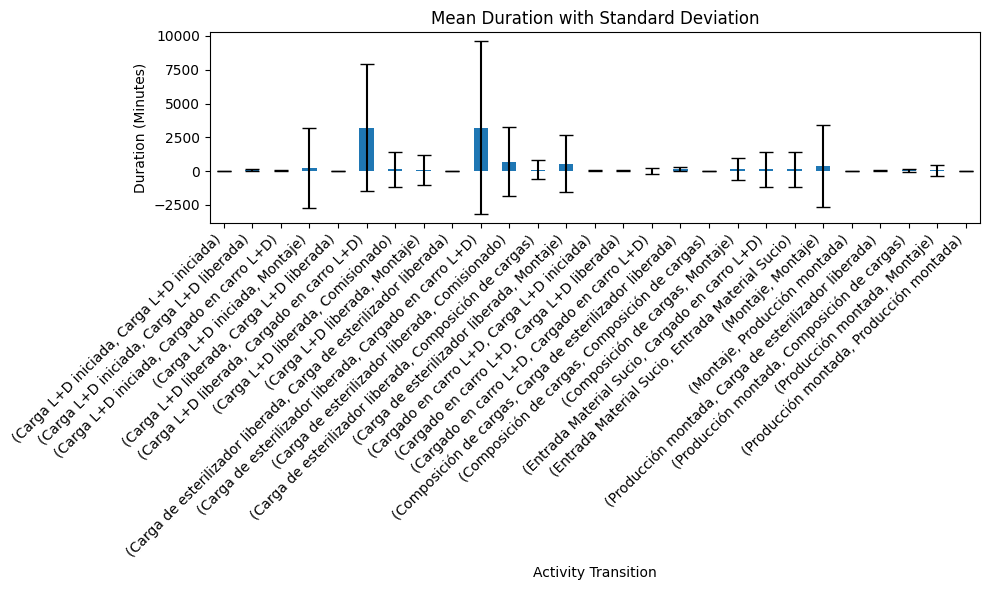

In [38]:

# Plotting mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
grouped['mean'].plot(kind='bar', yerr=grouped['std'], capsize=5)
plt.xlabel('Activity Transition')
plt.ylabel('Duration (Minutes)')
plt.title('Mean Duration with Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



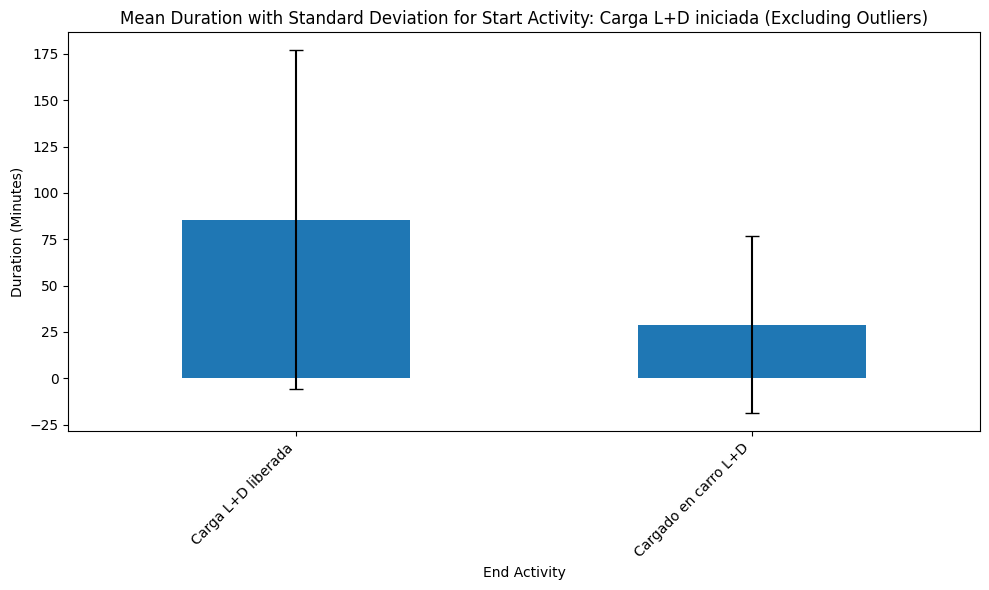

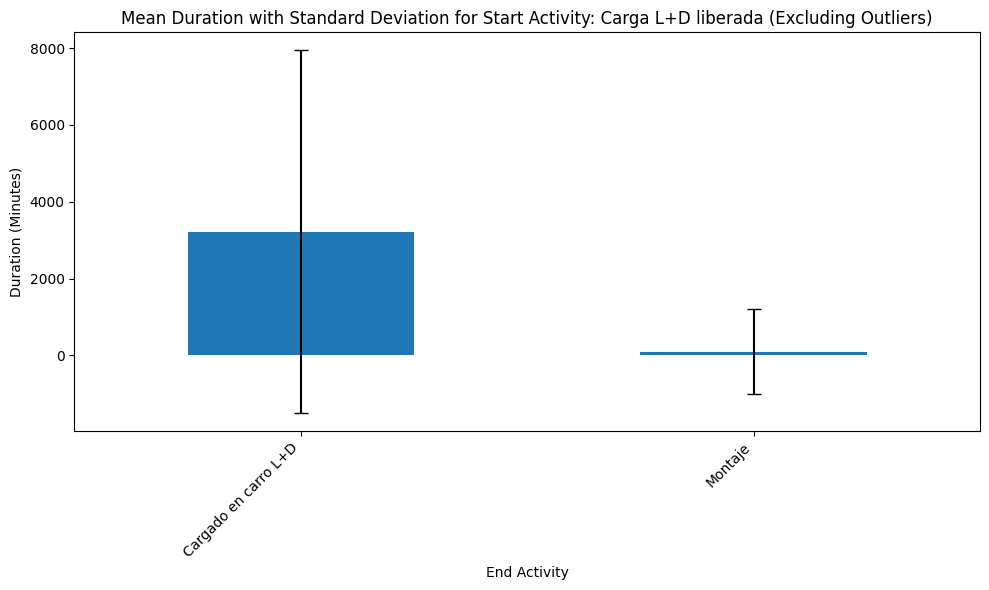

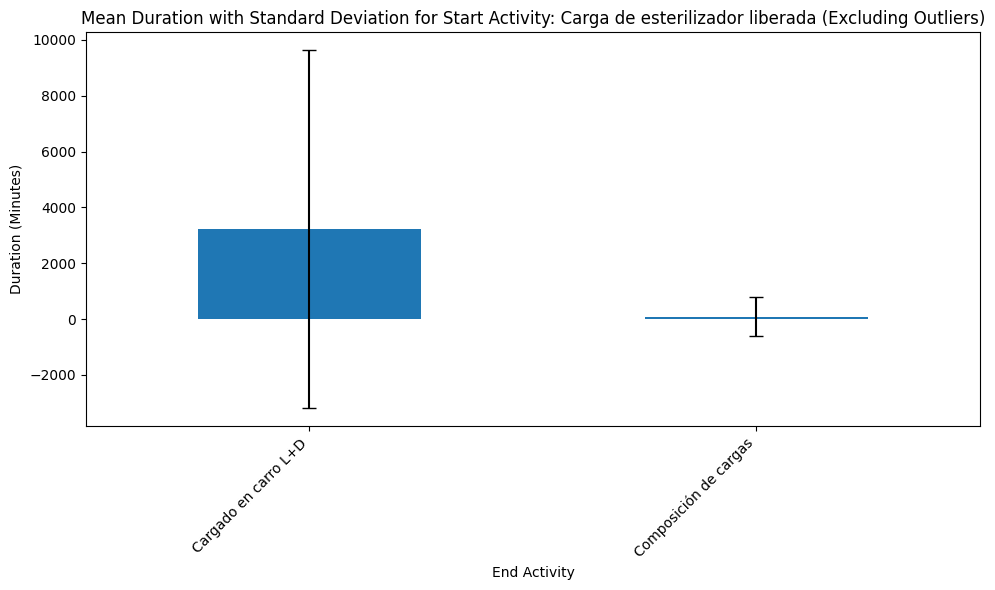

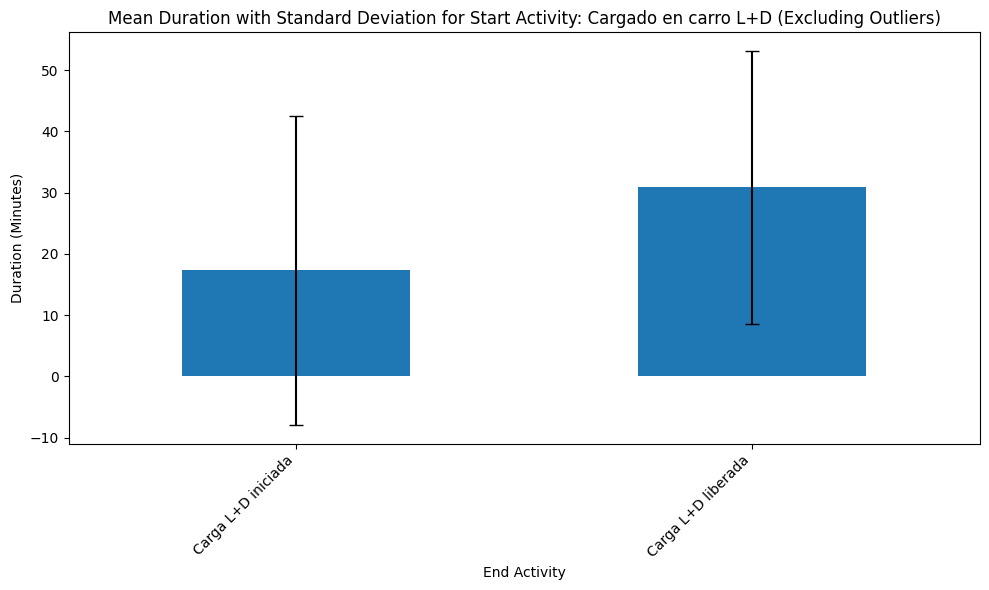

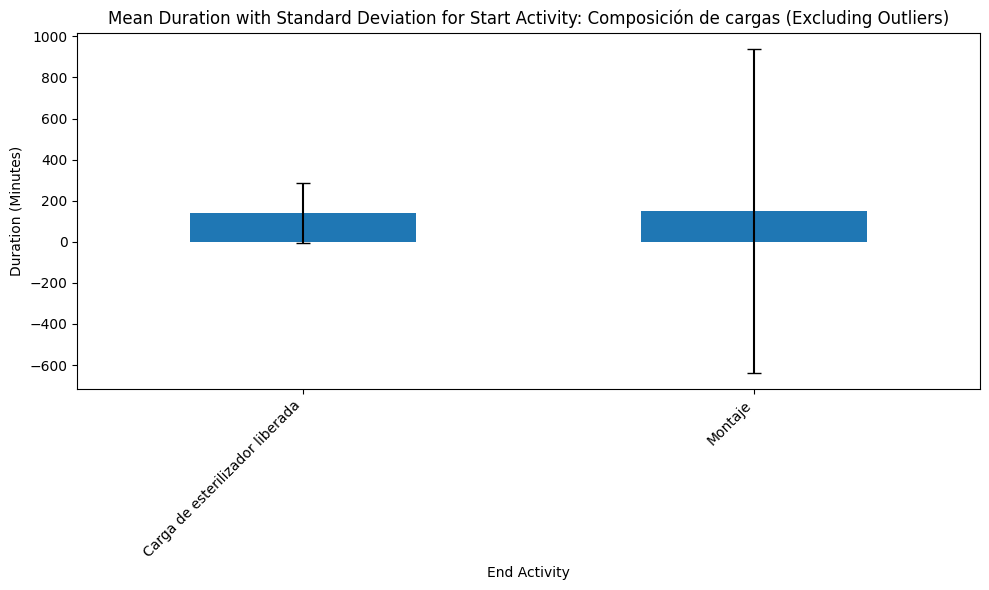

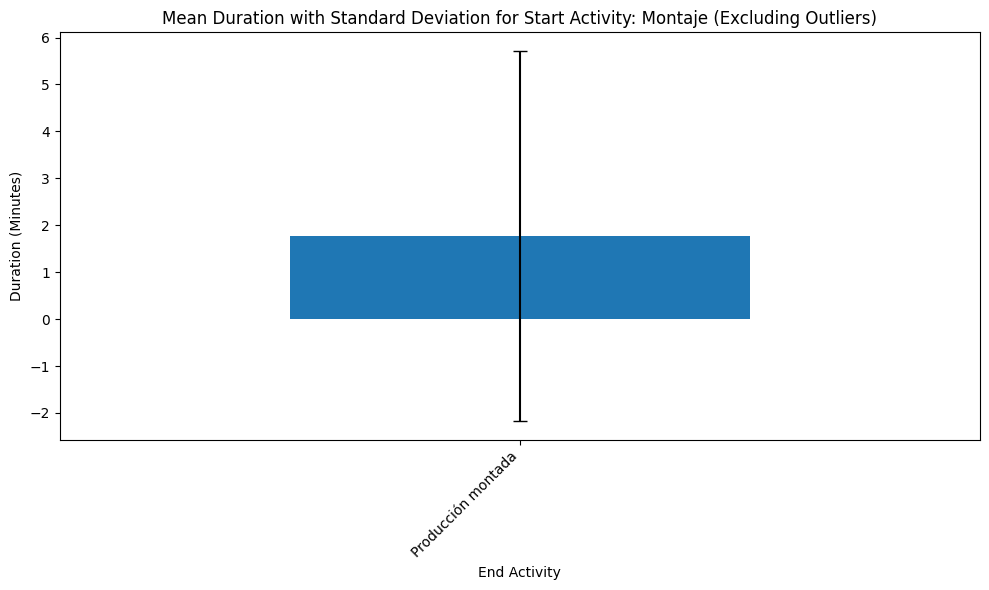

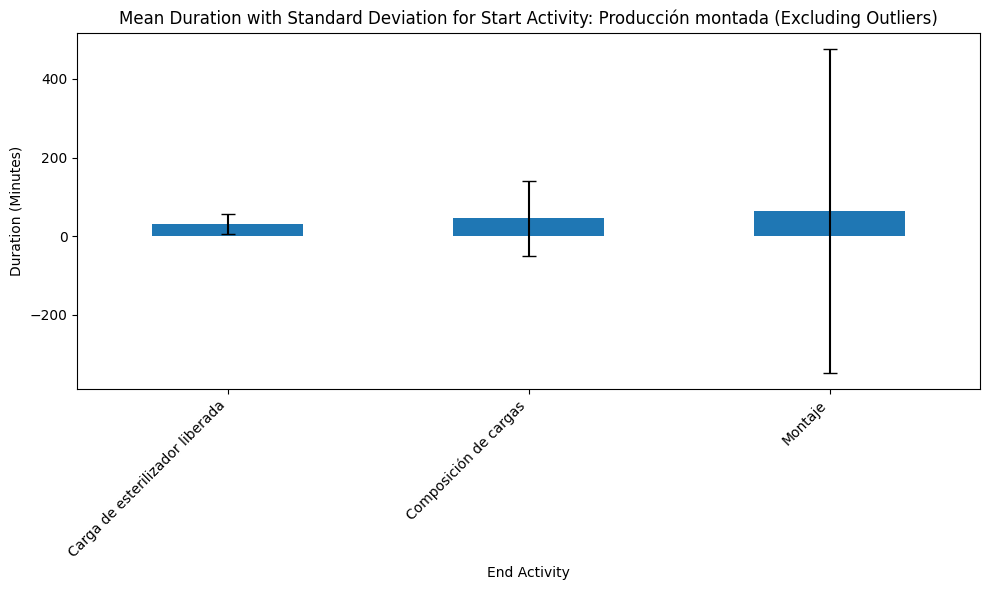

In [40]:
start_activities = grouped.index.get_level_values('start.Activity').unique()

# Plot each start activity separately
for start_activity in start_activities:
    # Filter data for the current start activity and exclude outliers
    start_activity_data = grouped.loc[start_activity]
    Q1 = start_activity_data['25%']
    Q3 = start_activity_data['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    start_activity_data_filtered = start_activity_data[(start_activity_data['mean'] >= lower_bound) & (start_activity_data['mean'] <= upper_bound)]

    if not start_activity_data_filtered.empty:
    # Plotting mean with error bars (standard deviation) for filtered data
        plt.figure(figsize=(10, 6))
        start_activity_data_filtered['mean'].plot(kind='bar', yerr=start_activity_data_filtered['std'], capsize=5)
        plt.xlabel('End Activity')
        plt.ylabel('Duration (Minutes)')
        plt.title(f'Mean Duration with Standard Deviation for Start Activity: {start_activity} (Excluding Outliers)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


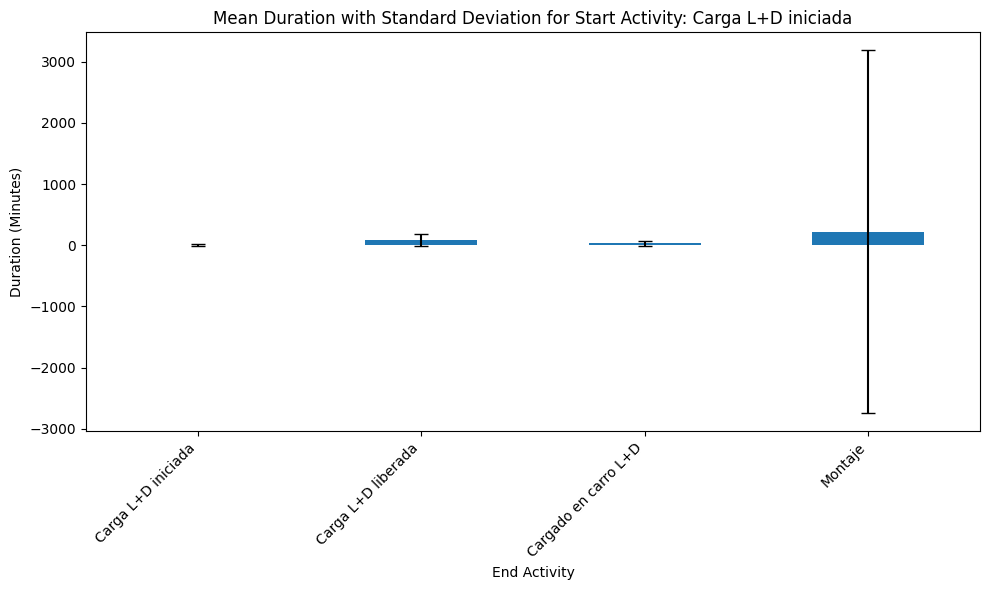

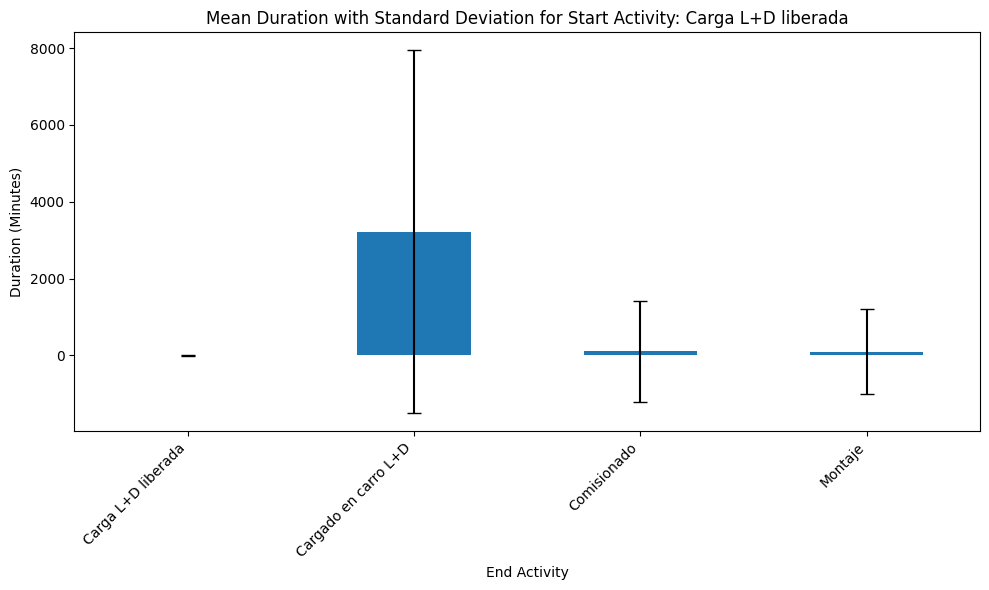

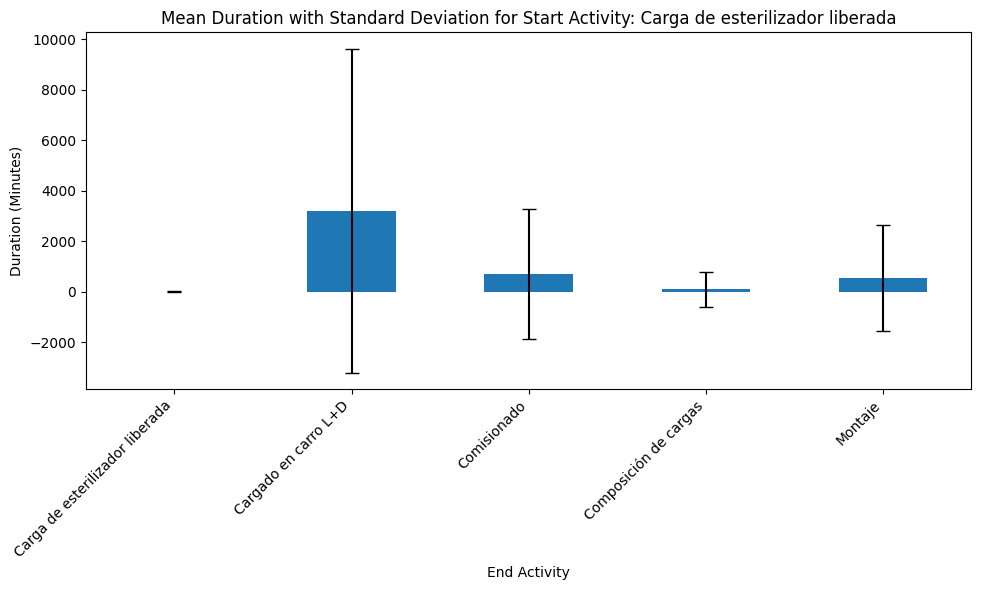

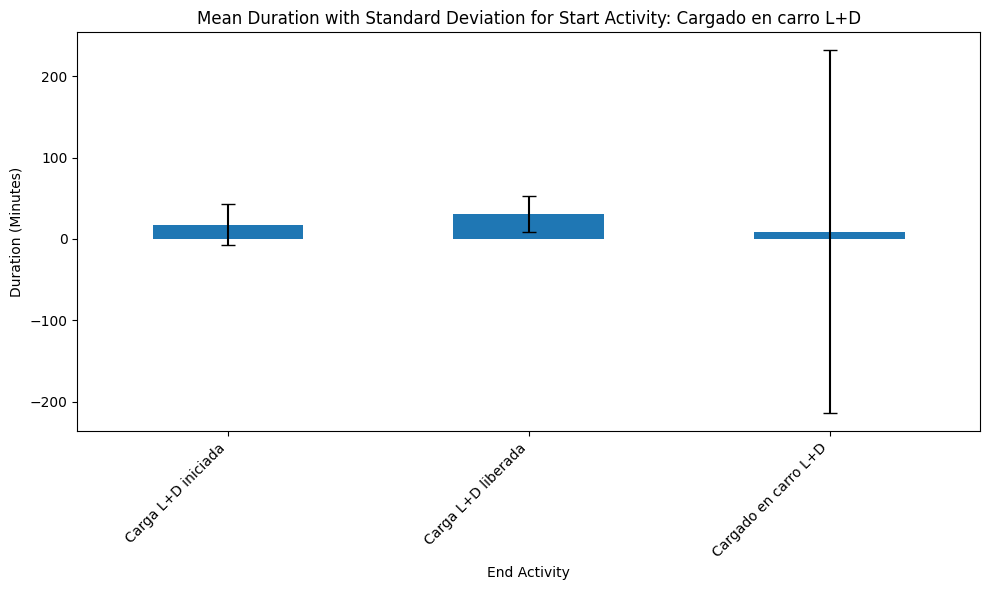

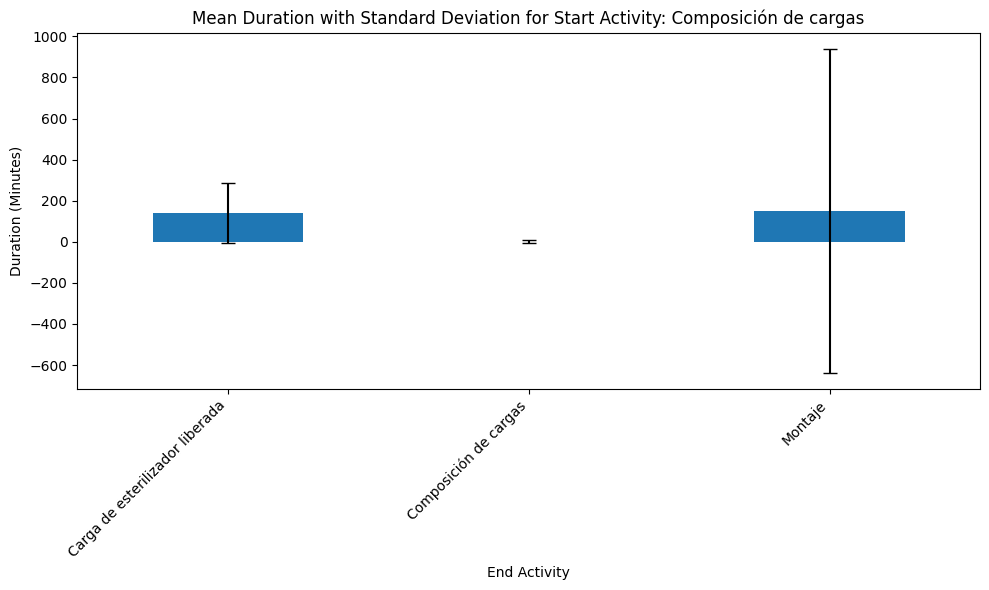

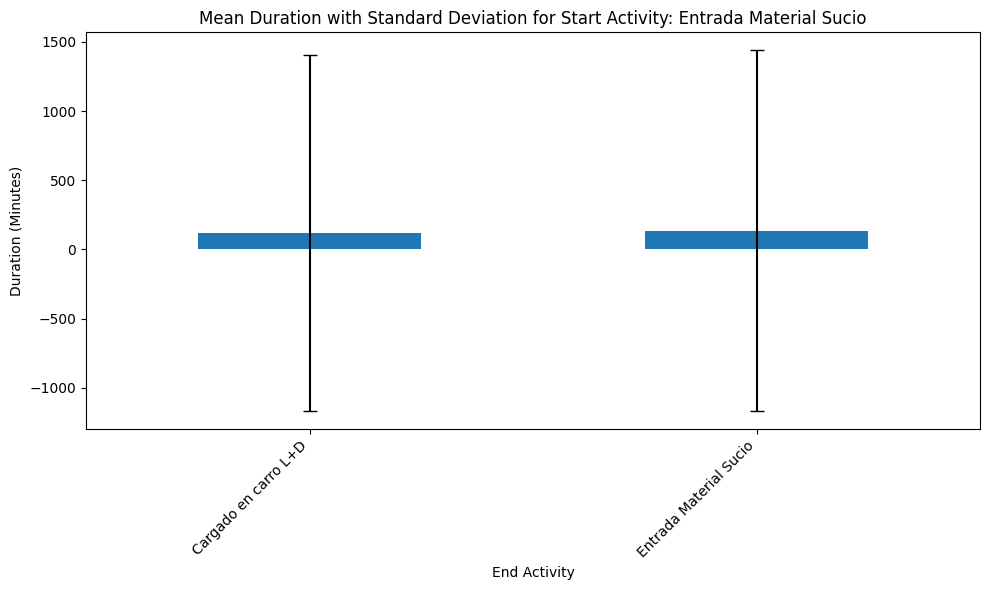

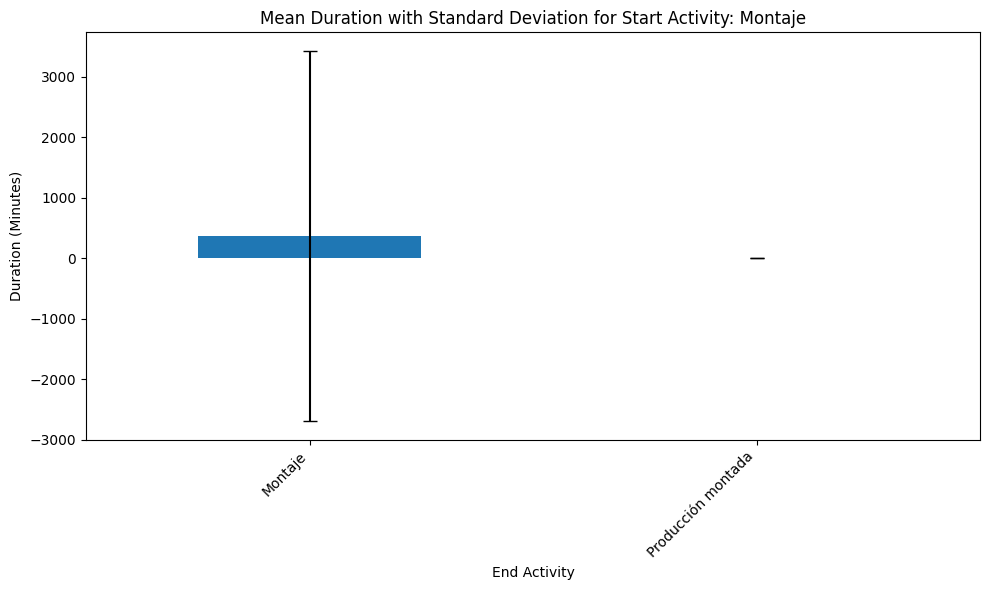

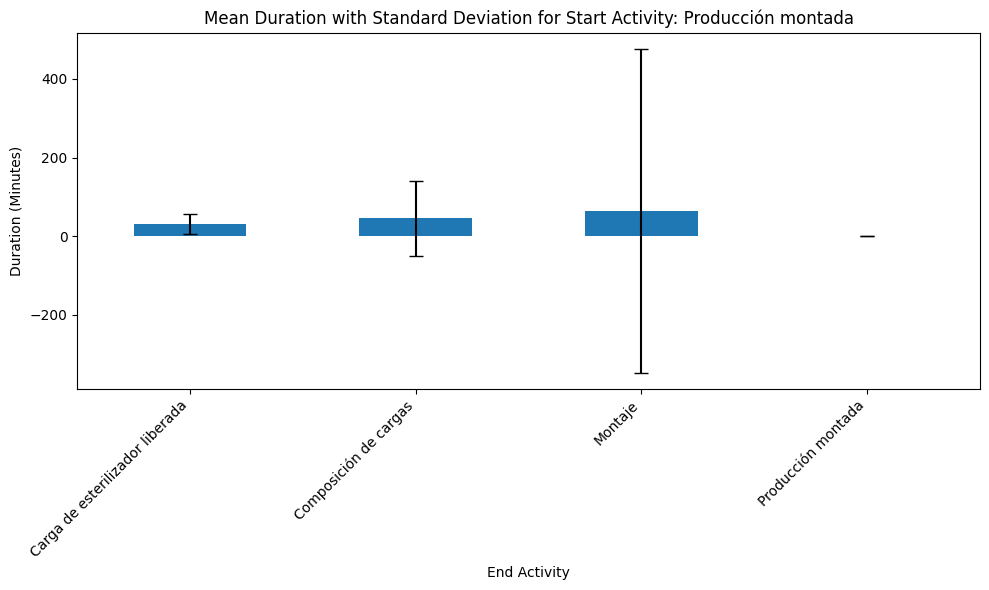

In [41]:
start_activities = grouped.index.get_level_values('start.Activity').unique()

# Plot each start activity separately
for start_activity in start_activities:
    # Filter data for the current start activity
    start_activity_data = grouped.loc[start_activity]

    # Plotting mean with error bars (standard deviation)
    plt.figure(figsize=(10, 6))
    start_activity_data['mean'].plot(kind='bar', yerr=start_activity_data['std'], capsize=5)
    plt.xlabel('End Activity')
    plt.ylabel('Duration (Minutes)')
    plt.title(f'Mean Duration with Standard Deviation for Start Activity: {start_activity}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Process duration based on the type of sterilization

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
Match (e) - [:CORR] -> (r:Run)
WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
return distinct(r.CaseID), r.durationInMinutes'''

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
Match (e) - [:CORR] -> (r:Run)
Match (e2:Event) - [c:CORR] -> (r)
MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
return distinct(r.CaseID), r.durationInMinutes'''

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
Match (e) - [:CORR] -> (r:Run)
WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
return distinct(r.CaseID), r.durationInMinutes'''

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            Match (e2:Event) - [c:CORR] -> (r)
            MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
            with distinct(r.durationInMinutes) as durationList
            with apoc.agg.statistics(durationList) as dualTempStat

            MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
            with distinct(r.durationInMinutes) as durationList, dualTempStat
            with apoc.agg.statistics(durationList) as lowTempStat, dualTempStat

            MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
            with distinct(r.durationInMinutes) as durationList, lowTempStat, dualTempStat
            with apoc.agg.statistics(durationList) as highTempStat, lowTempStat, dualTempStat

            return lowTempStat, dualTempStat, highTempStat
            '''

session.run(query).data()

## Extractions

### Extract kits based on the sterilization type

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            Match (e2:Event) - [c:CORR] -> (r)
            MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
            with distinct(k.ID) as dualTempStatKit
            return collect(dualTempStatKit) as dualTempStatKitList
        '''
session.run(query).data()

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (k) - [:HAS_UNIT] -> (:Entity) <- [:HAS_RUN] - (:Run) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
            with distinct(k.ID) as lowTempStatKit
            return collect(lowTempStatKit) as lowTempStatKitList
            '''
session.run(query).data()

In [ ]:
query = f'''MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (k) - [:HAS_UNIT] -> (:Entity) <- [:HAS_RUN] - (:Run) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
            with distinct(k.ID) as highTempStatKit
            return collect(highTempStatKit) as highTempStatKitList'''
session.run(query).data()

### Extract total processing time

In [ ]:
query = f'''Match (k:Kit) - [:HAS_UNIT] -> (e:Entity)
match (e) <- [:HAS_RUN] - (r:Run)
return k.ID, k.numberOfUnits, e.ID, e.numberOfCycles, r.CaseID, r.start_timestamp, r.end_timestamp, collect(r.activities)'''

frame = pd.DataFrame(session.run(query).data())
frame['r.start_timestamp'] = pd.to_datetime(frame['r.start_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['r.end_timestamp'] = pd.to_datetime(frame['r.end_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['durationInDays'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 / 60 / 24
frame['durationInHours'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 / 60 
frame['durationInMinutes'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 
csv_file_path = "/Users/abdalrhman/Documents/preparationphase/tableau/case_duration.csv"
frame.to_csv(csv_file_path, index=False)
frame.head()

### Extract kits based on the washing machine

In [ ]:
query = '''MATCH (w:WashingMachine {machine: "Jupiter"}) <- [:WASHED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInJupiter, en.ID as ent
            return kitsWashedInJupiter, collect(distinct(ent)) as entities'''
session.run(query).data()

In [ ]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Caducado"}) <- [:WASHED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInEsclusaCaducado, en.ID as ene
            return kitsWashedInEsclusaCaducado, collect(distinct(ene)) as entities'''
session.run(query).data()

In [ ]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Lavado"}) <- [:WASHED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInEsclusaLavado, en.ID as ene
            return kitsWashedInEsclusaLavado, collect(distinct(ene)) as entities'''
session.run(query).data()

In [ ]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Reposicion"}) <- [:WASHED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            with distinct(k.ID) as kitsWashedInEsclusaReposicion, en.ID as ene
            return kitsWashedInEsclusaReposicion, collect(distinct(ene)) as entities'''
session.run(query).data()